In [1]:
import glob
import json
import os

import re
from collections import Counter, defaultdict

from datetime import datetime
from operator import itemgetter, methodcaller
import time

import itertools
import requests
from tqdm import tqdm
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt

In [2]:
res1 = r"(<[^>]*>)"
res2 = r"(-(\n|\r|\r\n|\x0b|\x0c|\x1c|\x1d|\x1e|\x85|\u2028|\u2029))"
com1 = re.compile(res1, re.IGNORECASE)
com2 = re.compile(res2, re.IGNORECASE)
task_name = 'any2txt|wcrft2|liner2({"model":"n82"})'
url = 'http://ws.clarin-pl.eu/nlprest2/base'
res_path = 'data/result_back'

In [3]:
def json_file():
    for name in ("judgments-1571.json", "judgments-1572.json"):
        with open(os.path.join("data", "json", name), "r") as f:
            yield json.load(f)

def given_date(date):
    z = datetime.strptime(date, '%Y-%m-%d')
    return z.year == 2015

def sort_by_date():
    res = []
    for file in tqdm(json_file()):
        for y in file['items']:
            if given_date(y['judgmentDate']):
                res.append(y)
    res.sort(key=itemgetter('judgmentDate'))
    return res[:100]

In [4]:
def process(data):
    ids = requests.post('{}/upload/'.format(url), data=data.encode('utf-8'),
                        headers={'Content-Type': 'binary/octet-stream'}
                        ).text
    task = requests.post(url='{}/startTask/'.format(url),
                         json={'lpmn': task_name, 'file': ids, 'user': ''},
                         headers={'Content-Type': 'application/json'}
                         ).text

    status = requests.get(url='{}/getStatus/{}'.format(url, task)).json()
    while status['status'] in ('QUEUE', 'PROCESSING'):
        time.sleep(1)
        tqdm.write(status['status'])
        status = requests.get(url='{}/getStatus/{}'.format(url, task)).json()

    if status['status'] == 'DONE' and status['value']:
        processed = status['value'][0]['fileID']
        tqdm.write(status['status'])
        return requests.get(url='{}/download{}'.format(url, processed)).text

    elif status['status'] == 'ERROR':
        tqdm.write(status['status'])
        tqdm.write('Error: ', status['value'])

In [5]:
def from_files(paths):
    for name in glob.glob(os.path.join(paths, "*")):
        with open(name, "r") as f:
            tree = ET.parse(f)
        yield from tree.getroot().iter("tok")

In [6]:
def start_proccess():
    res = sort_by_date()
    i = 0
    for y in tqdm(res):
        done = process(com2.sub("", com1.sub("", y['textContent'])))
        if done:
            with open(os.path.join(res_path, str(i)), "w") as f:
                f.write(done)
        i += 1

In [7]:
left, right = itertools.tee(map(lambda t: t.attrib['chan'], 
                                itertools.chain.from_iterable(map(methodcaller('findall', "ann"), 
                                                                  from_files(res_path)))))

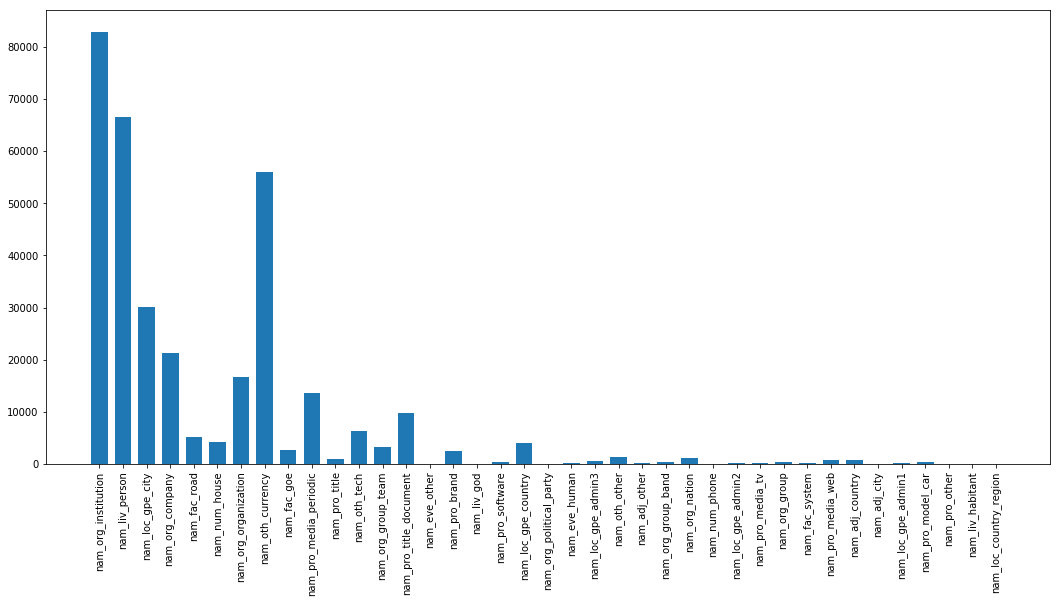

In [8]:
plt.figure(figsize=(18,10))
labels, values = zip(*Counter(right).items())
width = 0.7
indexes = np.arange(len(labels))

plt.bar(indexes, values, width)
plt.xticks(indexes, labels, rotation='vertical')
plt.subplots_adjust(bottom=0.25)
plt.show()

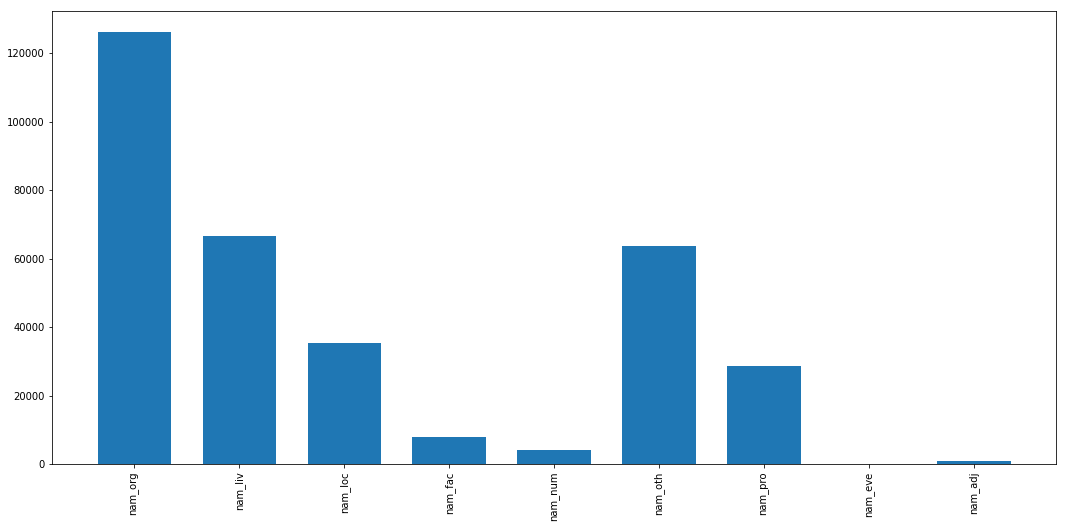

In [9]:
plt.figure(figsize=(18,10))
labels, values = zip(*Counter(map(lambda x: x[:x.find("_", x.find("_")+1)], left)).items())
indexes = np.arange(len(labels))
plt.bar(indexes, values, width)
plt.xticks(indexes, labels, rotation='vertical')
plt.subplots_adjust(bottom=0.25)
plt.show()

In [10]:
left, right = itertools.tee(map(lambda t: t.attrib['chan'], filter(lambda t: int(t.text) >0
                                ,itertools.chain.from_iterable(map(methodcaller('findall', "ann"), 
                                                                  from_files(res_path))))))

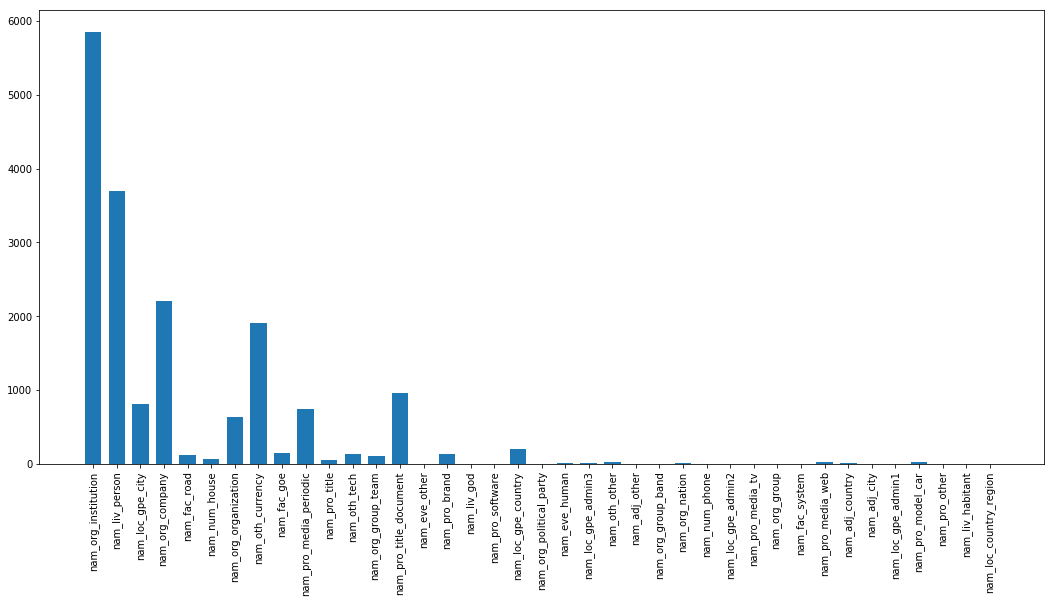

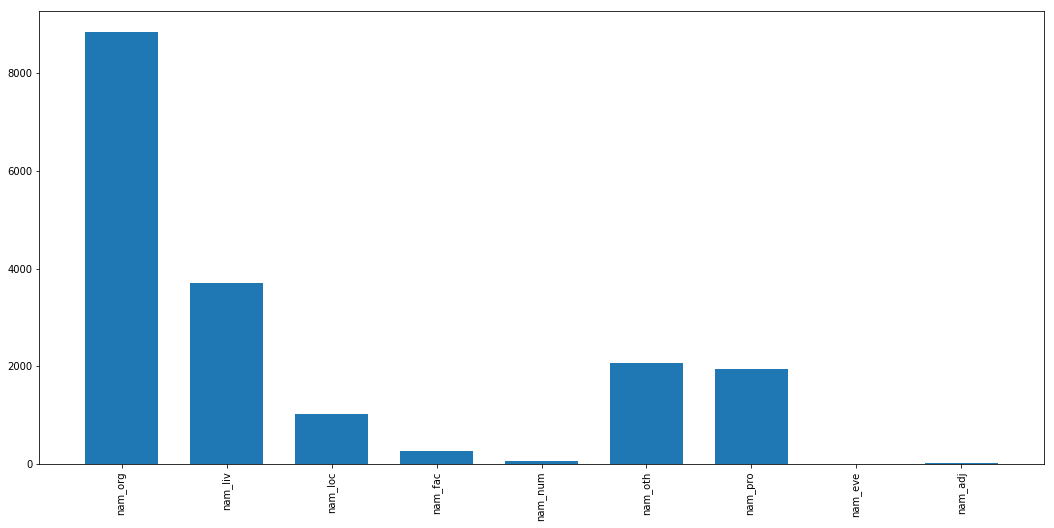

In [11]:
plt.figure(figsize=(18,10))
labels, values = zip(*Counter(right).items())
width = 0.7
indexes = np.arange(len(labels))

plt.bar(indexes, values, width)
plt.xticks(indexes, labels, rotation='vertical')
plt.subplots_adjust(bottom=0.25)
plt.show()

plt.figure(figsize=(18,10))
labels, values = zip(*Counter(map(lambda x: x[:x.find("_", x.find("_")+1)], left)).items())
indexes = np.arange(len(labels))
plt.bar(indexes, values, width)
plt.xticks(indexes, labels, rotation='vertical')
plt.subplots_adjust(bottom=0.25)
plt.show()

In [12]:
seeds = Counter(map(lambda k: (k[0].find('base').text, k[1].attrib['chan']),
                    filter(lambda m: m[1] is not None and m[0] is not None, 
                           map(lambda t: (t.find("lex"), t.find('ann')), from_files(res_path)))))
print('\n'.join(map(lambda k: f"\033[1m{k[0][0]}\033[0m -> {k[0][1]}: {k[1]}", seeds.most_common(100))))


. -> nam_liv_person: 6476
. -> nam_org_institution: 6163
. -> nam_oth_currency: 4217
, -> nam_org_institution: 2840
w -> nam_org_institution: 2745
, -> nam_liv_person: 2394
, -> nam_oth_currency: 2250
w -> nam_liv_person: 1745
. -> nam_org_company: 1642
złoty -> nam_oth_currency: 1565
z -> nam_org_institution: 1523
. -> nam_org_organization: 1328
w -> nam_oth_currency: 1274
) -> nam_liv_person: 1251
( -> nam_liv_person: 1241
sąd -> nam_org_institution: 1236
z -> nam_liv_person: 1074
. -> nam_loc_gpe_city: 931
) -> nam_oth_currency: 895
( -> nam_oth_currency: 857
na -> nam_org_institution: 852
( -> nam_org_institution: 827
i -> nam_org_institution: 825
) -> nam_org_institution: 800
z -> nam_oth_currency: 725
. -> nam_oth_tech: 720
kwota -> nam_oth_currency: 707
i -> nam_liv_person: 691
k -> nam_liv_person: 690
. -> nam_pro_title_document: 686
1 -> nam_liv_person: 682
dzień -> nam_org_institution: 667
k -> nam_org_institution: 666
na -> nam_oth_currency: 627
o -> nam_org_institution: 595

In [13]:
seeds = Counter(map(lambda k: (k[0].find('base').text, k[1].attrib['chan']),
                    filter(lambda m: m[1] is not None and int(m[1].text) > 0, 
                           map(lambda t: (t.find("lex"), t.find('ann')), from_files(res_path)))))
print('\n'.join(map(lambda k: f"\033[1m{k[0][0]}\033[0m -> {k[0][1]}: {k[1]}", seeds.most_common(100))))

    

złoty -> nam_oth_currency: 1494
sąd -> nam_org_institution: 1078
. -> nam_liv_person: 689
M -> nam_liv_person: 421
rejonowy -> nam_org_institution: 403
okręgowy -> nam_org_institution: 381
. -> nam_org_company: 373
w -> nam_org_institution: 247
bajt -> nam_liv_person: 198
sekunda -> nam_liv_person: 182
zamawiać -> nam_liv_person: 162
. -> nam_pro_media_periodic: 149
J -> nam_liv_person: 138
sekunda -> nam_org_company: 124
gram -> nam_liv_person: 117
najwyższy -> nam_org_institution: 113
i -> nam_org_institution: 101
D -> nam_liv_person: 99
k -> nam_liv_person: 95
o -> nam_org_company: 94
skarb -> nam_org_institution: 92
państwo -> nam_org_institution: 92
urząd -> nam_org_institution: 92
L -> nam_liv_person: 87
izba -> nam_org_institution: 84
odwoławczy -> nam_org_institution: 81
krajowy -> nam_org_institution: 80
a -> nam_org_company: 79
u -> nam_pro_media_periodic: 74
apelacyjny -> nam_org_institution: 68
spółka -> nam_org_company: 65
dziennik -> nam_pro_media_periodic: 61
wydział -> 

In [19]:
seeds = Counter(map(lambda k: (k[0].find('base').text, k[1].attrib['chan']),
                    filter(lambda m: m[1] is not None and int(m[1].text) > 0, itertools.chain.from_iterable(
                           map(lambda t: itertools.product(t.findall("lex"), t.findall('ann')), from_files(res_path))))))
print('\n'.join(map(lambda k: f"\033[1m{k[0][0]}\033[0m -> {k[0][1]}: {k[1]}", seeds.most_common(100))))

złoty -> nam_oth_currency: 1892
sąd -> nam_org_institution: 1183
. -> nam_liv_person: 784
. -> nam_org_company: 598
M -> nam_liv_person: 483
okręgowy -> nam_org_institution: 427
rejonowy -> nam_org_institution: 424
. -> nam_pro_media_periodic: 336
w -> nam_org_institution: 286
bajt -> nam_liv_person: 221
bit -> nam_liv_person: 221
sekunda -> nam_liv_person: 202
zamawiać -> nam_liv_person: 191
sekunda -> nam_org_company: 181
u -> nam_pro_media_periodic: 167
o -> nam_org_company: 166
J -> nam_liv_person: 161
najwyższy -> nam_org_institution: 139
dziennik -> nam_pro_media_periodic: 134
skarb -> nam_org_institution: 132
państwo -> nam_org_institution: 132
izba -> nam_org_institution: 128
gram -> nam_liv_person: 126
urząd -> nam_org_institution: 126
krajowy -> nam_org_institution: 122
odwoławczy -> nam_org_institution: 118
a -> nam_org_company: 117
k -> nam_liv_person: 117
spółka -> nam_org_company: 116
D -> nam_liv_person: 113
i -> nam_org_institution: 108
Warszawa -> nam_loc_gpe_city: 105

In [14]:
mab = defaultdict(Counter)
for name, ort in map(lambda x: (x[1][:x[1].find("_", x[1].find("_")+1)], x[0]), map(lambda k: (k[0].text, k[1].attrib['chan']), filter(lambda m: m[1] is not None,
                                                               map(lambda t: (t.find("lex").find("base"), t.find('ann')),
                                                                   from_files(res_path))))):
    mab[name][ort] +=1
for a,b in mab.items():
    print(f"{a}: ", ' '.join(map(lambda y: y[0],b.most_common(10))))

nam_org:  . , w z ( sąd ) na i k
nam_liv:  . , w ) ( z i k 1 na
nam_loc:  . w , z ) o ( na do i
nam_oth:  . , złoty w ) ( z kwota na -
nam_fac:  . , w z ) ( i na do o
nam_pro:  . , z w ) o ( i na r
nam_eve:  . , w i – do ( ) r akcja
nam_adj:  , . spółka w pozwana z niemiecki powódka że to
nam_num:  . k – - i to samo , D (


In [15]:
mab = defaultdict(Counter)
for name, ort in map(lambda x: (x[1][:x[1].find("_", x[1].find("_")+1)], x[0]), map(lambda k: (k[0].text, k[1].attrib['chan']), filter(lambda m: m[1] is not None and int(m[1].text) >0,
                                                               map(lambda t: (t.find("lex").find("base"), t.find('ann')),
                                                                   from_files(res_path))))):
    mab[name][ort] +=1
for a,b in mab.items():
    print(f"{a}: ", ' '.join(map(lambda y: y[0],b.most_common(10))))

nam_org:  sąd rejonowy . okręgowy w sekunda najwyższy i M o
nam_liv:  . M bajt sekunda zamawiać J gram D k L
nam_loc:  Warszawa L wielki Brytania izba Niemcy Polska zarząd USA spółka
nam_oth:  złoty VAT D M nowy_polski_złoty C III VII KW Internet
nam_fac:  . spółdzielnia sekunda L Hala e krajowy mieszkaniowy szpital P
nam_pro:  . u dziennik ustawa prawo publiczny zamówienie z o dzień
nam_eve:  druga wojna światowy etap i nabrzeże rumuński B.oraz 4 krajowy
nam_adj:  niemiecki unijny brytyjski amerykański
nam_num:  112


In [22]:
mab = defaultdict(Counter)
for name, ort in map(lambda x: (x[1][:x[1].find("_", x[1].find("_")+1)], x[0]), map(lambda k: (k[0].find('base').text, k[1].attrib['chan']), filter(lambda m: m[1] is not None and int(m[1].text) >0,
                                                                itertools.chain.from_iterable(map(lambda t: itertools.product(t.findall("lex"), t.findall('ann')),
                                                                   from_files(res_path)))))):
    mab[name][ort] +=1
for a,b in mab.items():
    print(f"{a}: ", ' '.join(map(lambda y: y[0],b.most_common(10))))

nam_org:  sąd . okręgowy rejonowy w sekunda o najwyższy skarb państwo
nam_liv:  . M bajt bit sekunda zamawiać J gram k D
nam_loc:  Warszawa warszawa Wrocław wielki Brytania brytania Łódź łódź Poznań Krak
nam_fac:  krajowy droga Hala hala e . spółdzielnia sekunda L szpital
nam_num:  17 14 16 11 6 47 46 118 24 74
nam_oth:  złoty VAT D nowy_polski_złoty M C III VII KW L
nam_pro:  . u dziennik ustawa z o prawo dzień publiczny zamówienie
nam_eve:  druga wojna światowy etap i nabrzeże rumuński B.oraz 4 oddział
nam_adj:  niemiecki unijny brytyjski internetowy amerykański
